In [290]:
import sklearn
import xgboost
import keras
import numpy
import matplotlib.pyplot as pyplot
import matplotlib
matplotlib.rcParams['font.size'] = 16
import math
import scipy

# Machine Learning Intro & Decision Trees

### Peter Onyisi

## What is ... Machine Learning?

There's a family of techniques, which are more or less the same in practice, that in particle physics gets called a number of things:
* multivariate analysis
* machine learning
* artificial intelligence

As one goes from top to bottom of that list, the main qualitative difference is that the methods get more "black box" and opaque; the simplest MVA techniques are straightforward and easy for humans to reason about, while AI can appear to be magic.  But they're all best understood as being variants along an axis.

Machine learning is a term for "higher-order" programming techniques, in which a computer is given a way to determine a _function_ that optimizes certain properties (as opposed to just computing a function given to it by a user).  Some things people in particle physics try to do with machine learning are:
* _classification_: from some observed data, what produced it? (Is this jet a b-jet? Was this event produced by a ttH decay?) This may also be able to produce _probabilities_ of observed data arising from different sources ("belonging to different classes").  Generally we only do _supervised learning_, where we know what characteristics we want the algorithm to learn, but it is possible to do _unsuper
* _regression_: from some observed data, try to predict some continuous characteristic (from the pattern of energy deposits in the electromagnetic calorimeter, what was the true energy of this electron?)
* _density estimation_: given a set of discrete examples of events generated according to some multi-dimensional probability distribution function, can I get an estimate of that PDF at any location?

ML techniques require a metric to decide if the functions they've determined are good at their job.  These are called _loss_, _cost_, or _objective_ functions, and typically we aim to minimize the loss.

Typically a ML algorithm is _trained_ on some set of data, _tested_ on another to ensure its validity, then _generalized_ to other similar datasets.  The training/testing distinction is crucial because certain ML algorithms are prone to _overtraining_, where they learn features of the specific dataset being trained on (statistical fluctuations, noise, etc.) which lead the algorithm to be overconfident about its ability to generalize.  The testing phase "keeps the algorithm honest," so to speak.  It is also important when generalizing to understand if there are any systematic biases in the training/testing samples compared to the broader world - for example, in particle physics, typically the training/testing samples are simulation, while the samples to be generalized to are data, and errors in the simulation will show up as biases in the response of the function to data.

## How does one do Machine Learning?

Luckily, nobody has to program any of the core ML algorithms themselves these days (unless they're doing ML research of course). There are a number of packages to help; among the popular ones for particle physics:
* [TMVA](https://root.cern.ch/tmva) - the Toolkit for MultiVariate Analysis. This is part of the ROOT ecosystem, and plays very well with data in ROOT TTrees.  Supports a lot of techniques, reasonably friendly interface, but if your data aren't already in ROOT format it's a bit painful.
* [scikit-learn](https://scikit-learn.org/) - a standard Python library. Doesn't cover deep neural nets (or really NN in any sophistication).  Many Python tools provide an interface that a mimics that of scikit-learn.
* [XGBoost](https://xgboost.readthedocs.io/en/latest/) - A specific boosted decision tree library which has gotten very popular in HEP.
* [TensorFlow](https://www.tensorflow.org/)/[Keras](https://keras.io/) - a standard pairing of libraries to do sophisticated neural networks. TensorFlow is a low-level tool to actually define the form of the processing flow in a NN; Keras provides a nice Python interface to TF in terms of high-level NN concepts.  An "industry standard".
* [PyTorch](https://pytorch.org/) - The hipster alternative to TensorFlow/Keras for Python NN creation. More "research-focused".

Here I will use scikit-learn and TensorFlow/Keras to illustrate the main ideas.

## Feature Engineering

One of the simplest "multivariate analysis" techniques is very familiar to HEP folks - just make a cut on some property of the event.  But we know that this can be complicated.  Imagine data that looks like this:

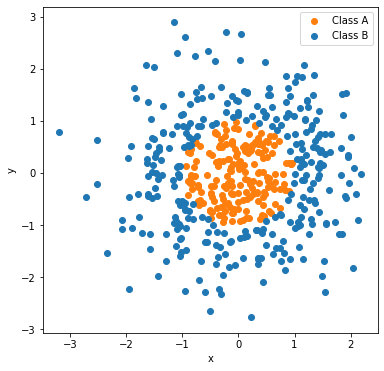

In [164]:
numpy.random.seed(20)
x = numpy.random.normal(size=[500,1])
y = numpy.random.normal(size=[500,1])
radii = numpy.hypot(x,y)
pyplot.figure(figsize=(6,6))
pyplot.scatter(numpy.extract(radii<1, x), numpy.extract(radii<1, y), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radii>1, x), numpy.extract(radii>1, y), label='Class B', color='tab:blue')
pyplot.xlabel('x'); pyplot.ylabel('y')
pyplot.legend()
pyplot.draw()

One _could_ try to distinguish the two classes using cuts in $x$ and $y$, but that would have to be a complicated structure of cuts. The clearly better (i.e., simpler) choice would be a single cut in $r$:

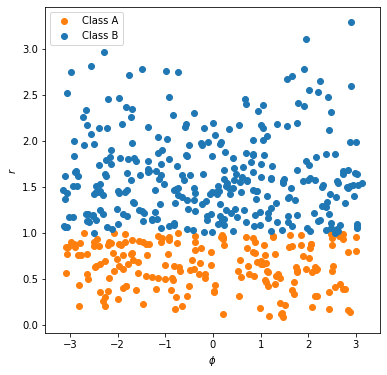

In [165]:
phi = numpy.arctan2(y, x)
pyplot.figure(figsize=(6,6))
pyplot.scatter(numpy.extract(radii<1, phi), numpy.extract(radii<1,radii), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radii>1, phi), numpy.extract(radii>1,radii), label='Class B', color='tab:blue')
pyplot.xlabel('$\phi$'); pyplot.ylabel('$r$')
pyplot.legend()
pyplot.draw()

The core point here is that difficult problems can be made much simpler by finding a good set of _features_ (= the inputs to the ML algorithm) to begin with. There can be important structure that is hidden by a bad choice of features.  Creating useful features is called _feature engineering_, and it is a very similar exercise to the kinds of things that we're used to doing for cut-based analysis (e.g. when we want to identify Z bosons, we use dilepton mass, not, say, by using complicated cuts on raw lepton four-vectors.)

People frequently perform a few preprocessing steps before running further analysis - for example scaling and shifting the features to zero mean and unit standard deviation, or "principal component analysis" which finds linear combinations of the input variables that are decorrelated and ordered by how much variation there is along each axis.  These are not necessarily relevant for usual HEP use, but you might consider them in certain cases. (The following plot is a demonstration of a PCA decomposition, taken from Wikipedia ...)

![plot](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/800px-GaussianScatterPCA.svg.png)

One of the dreams of "deep learning" is to eliminate the need to do feature engineering: the computers themselves will engineer the features.  (In a very real sense this is what "deep" means, beyond just the shape of the neural networks: you can just feed in raw pixels/ADC counts/whatever, and "meaning" will be extracted automatically.)

There are two major classes of ML algorithms used for HEP today: decision tree-based algorithms and neural networks. Let's discuss DTs first.

A pure, unadorned DT is just a predetermined sequence of yes-no decisions made based on features, which eventually lead to a "leaf" - which could for example be a decision about the type of a data point (for classification) or a function value (for a regression problem). Let's look at a simple one...

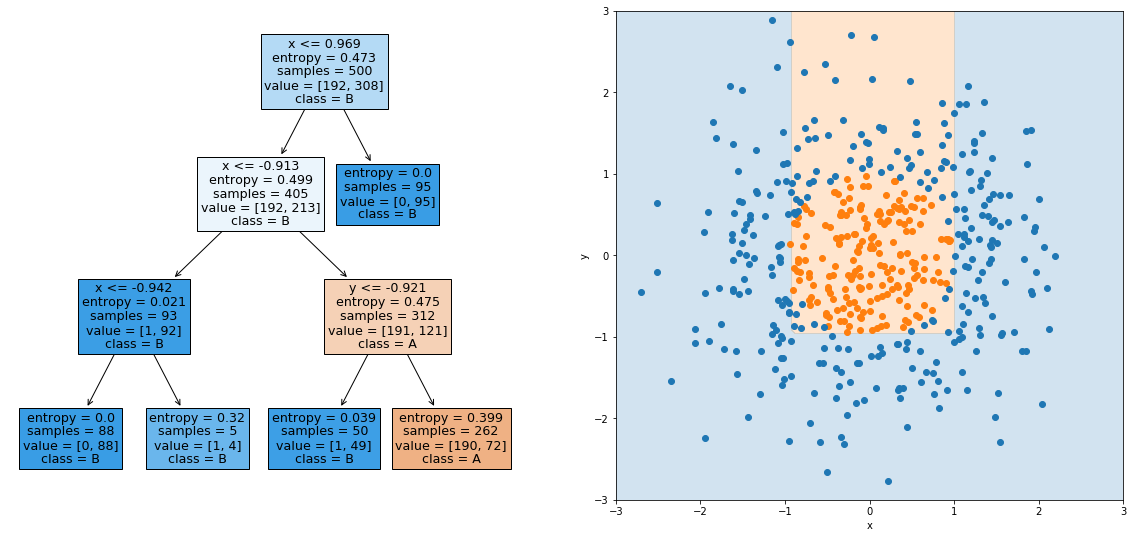

In [13]:
from sklearn import tree
xy = numpy.concatenate((x, y), axis=1)
t = tree.DecisionTreeClassifier(max_depth=3).fit(xy, (radii>1).astype(int))
pyplot.figure(figsize=(20,9))
pyplot.subplot(1,2,1)
tree.plot_tree(t, class_names=['A', 'B'], feature_names=['x', 'y'], filled=True)
pyplot.subplot(1,2,2)
xx, yy = numpy.meshgrid(numpy.linspace(-3, 3, 151), numpy.linspace(-3,3,151))
vals = t.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(radii<1, x), numpy.extract(radii<1, y), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radii>1, x), numpy.extract(radii>1, y), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.xlabel('x'); pyplot.ylabel('y')
pyplot.draw()

Unfortunately a tree of depth three is unable to make a four-sided box!

Clearly we would do better with $r$-$\phi$:

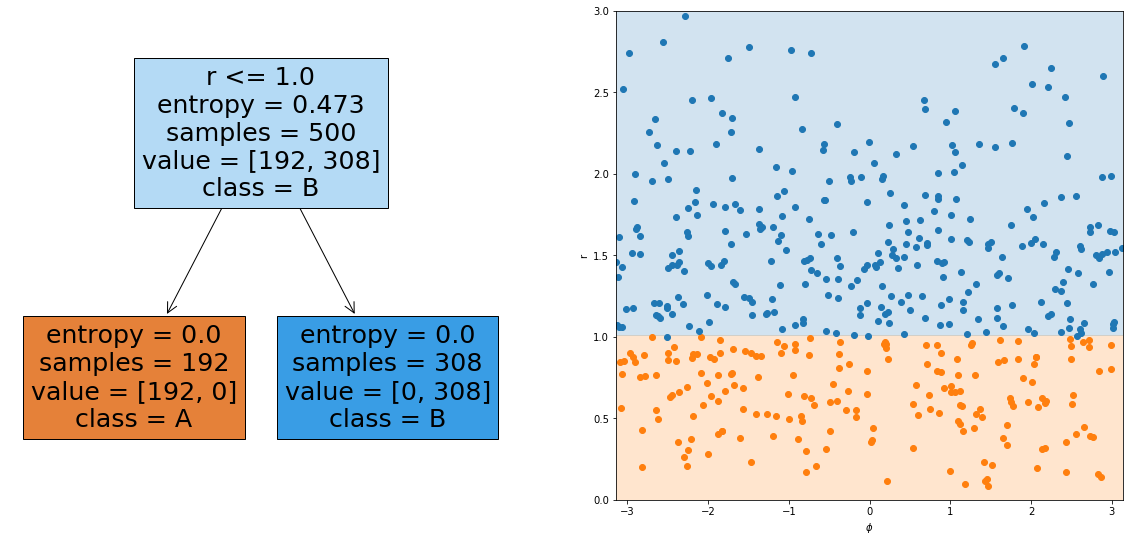

In [16]:
rphi = numpy.concatenate((phi, radii), axis=1)
t = tree.DecisionTreeClassifier(max_depth=3).fit(rphi, (radii>1).astype(int))
pyplot.figure(figsize=(20,9))
pyplot.subplot(1,2,1)
tree.plot_tree(t, class_names=['A', 'B'], feature_names=['$\phi$', 'r'], filled=True)
pyplot.subplot(1,2,2)
xx, yy = numpy.meshgrid(numpy.linspace(-math.pi, math.pi, 601), numpy.linspace(0,3,601))
vals = t.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(radii<1, phi), numpy.extract(radii<1, radii), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radii>1, phi), numpy.extract(radii>1, radii), label='Class B', color='tab:blue')
pyplot.xlim(-math.pi,math.pi); pyplot.ylim(-0,3)
pyplot.xlabel('$\phi$'); pyplot.ylabel('r')
pyplot.draw()

With a more appropriate set of features, a one-level tree is able to do the job.

Now, if we allowed more depth to the tree, we could do better in $x$-$y$ space...

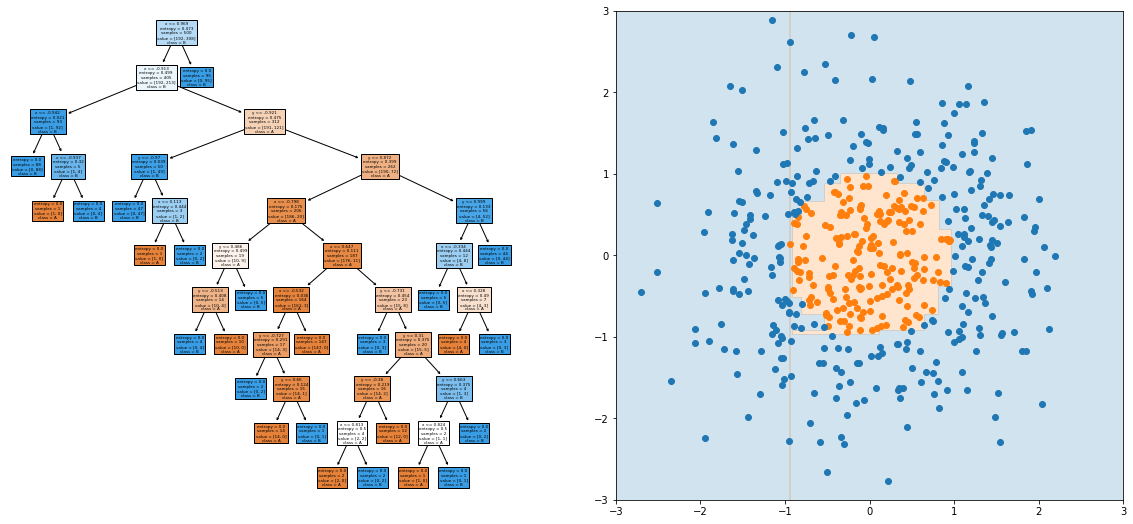

In [233]:
xy = numpy.concatenate((x, y), axis=1)
t = tree.DecisionTreeClassifier(max_depth=20).fit(xy, (radii>1).astype(int))
pyplot.figure(figsize=(20,9))
pyplot.subplot(1,2,1)
tree.plot_tree(t, class_names=['A', 'B'], feature_names=['x', 'y'], filled=True)
pyplot.subplot(1,2,2)
xx, yy = numpy.meshgrid(numpy.linspace(-3, 3, 901), numpy.linspace(-3,3, 901))
vals = t.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(radii<1, x), numpy.extract(radii<1, y), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radii>1, x), numpy.extract(radii>1, y), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.draw()

Now, one can see that this is not a perfect circle - it can't be, since it's formed from a bunch of rectangular cuts. It manages to exactly categorize every event that we've given it (which is not so crazy, since 10 cuts would be enough to classify 2<sup>10</sup> = 1024 events perfectly).  But it clearly won't quite work if we generate another set of events with the same true distribution:

Number of prediction fails: 18 (3.6%))


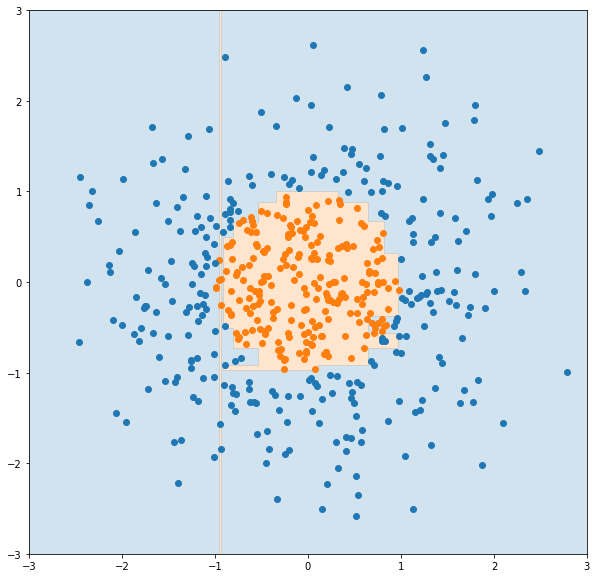

In [199]:
numpy.random.seed(23)
xytest = numpy.random.normal(size=[500,2])
radiitest = numpy.hypot(xytest[...,0],xytest[...,1])
vals = t.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.figure(figsize=(10,10))
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(radiitest<1, xytest[...,1]), numpy.extract(radiitest<1, xytest[...,0]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(radiitest>1, xytest[...,1]), numpy.extract(radiitest>1, xytest[...,0]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.draw()
fails=sum(t.predict(xytest) ^ (radiitest>1).ravel())
print('Number of prediction fails: %d (%.1f%%))' % (fails, fails/len(xytest)*100))

So if we had used the training sample to estimate the performance on a generic dataset, we would have overestimated how well it would separate the two classes; this is called _overtraining_ or _overfitting_.  With a small number of training events, or a very deep decision tree, this can be a bit ludicrous:

Number of prediction fails for training sample: 0 (0.0%))
Number of prediction fails for testing sample: 253 (50.6%))


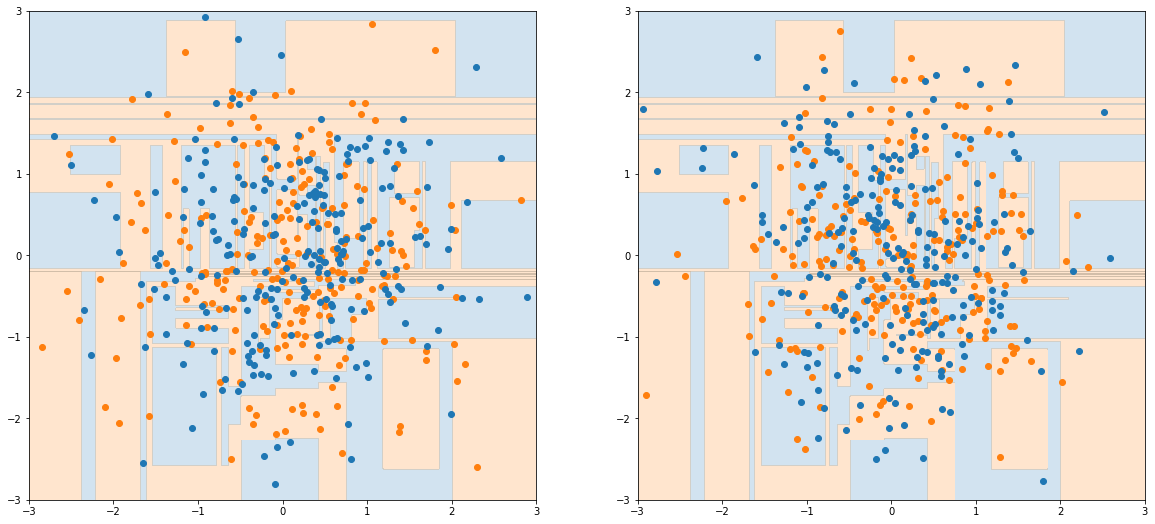

In [222]:
numpy.random.seed(25)
xy = numpy.random.normal(size=[500,2])
xytest = numpy.random.normal(size=[500,2])
classes = numpy.zeros(500).astype(int); classes[250:]=1
trand = tree.DecisionTreeClassifier(max_depth=20).fit(xy, classes)
vals = trand.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)

pyplot.figure(figsize=(20,9))
pyplot.subplot(1,2,1)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xy[...,0]), numpy.extract(classes==0, xy[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xy[...,0]), numpy.extract(classes==1, xy[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.subplot(1,2,2)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xytest[...,0]), numpy.extract(classes==0, xytest[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xytest[...,0]), numpy.extract(classes==1, xytest[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.draw()
fails=sum(trand.predict(xy) ^ (classes).ravel())
print('Number of prediction fails for training sample: %d (%.1f%%))' % (fails, fails/len(xy)*100))
fails=sum(trand.predict(xytest) ^ (classes).ravel())
print('Number of prediction fails for testing sample: %d (%.1f%%))' % (fails, fails/len(xytest)*100))

There are ways to avoid this kind of behavior, which we will come back to shortly.  One is to limit the depth of the tree (this is a _hyperparameter_, i.e. a parameter of the ML algorithm); one could imagine adding levels to the tree until the training and testing performance diverge. Another is to require that the leaves have a minimal number of entries, so you don't have leaves that represent a single training point.

We didn't actually discuss how the decision tree algorithm decides how to apply its cuts.  The general principle for standard decision trees is to try to figure out, at each step of building the tree, how to split leaves to maximally increase the separation between classes (e.g. by computing an entropy variable and seeing what split maximally reduces entropy).

A decision tree can predict the probability of a correct classification, based on the purity of the chosen leaf.  This is our first example of a "score" for a classifier:

Number of prediction fails for training sample: 158 (31.6%))
Number of prediction fails for testing sample: 139 (27.8%))


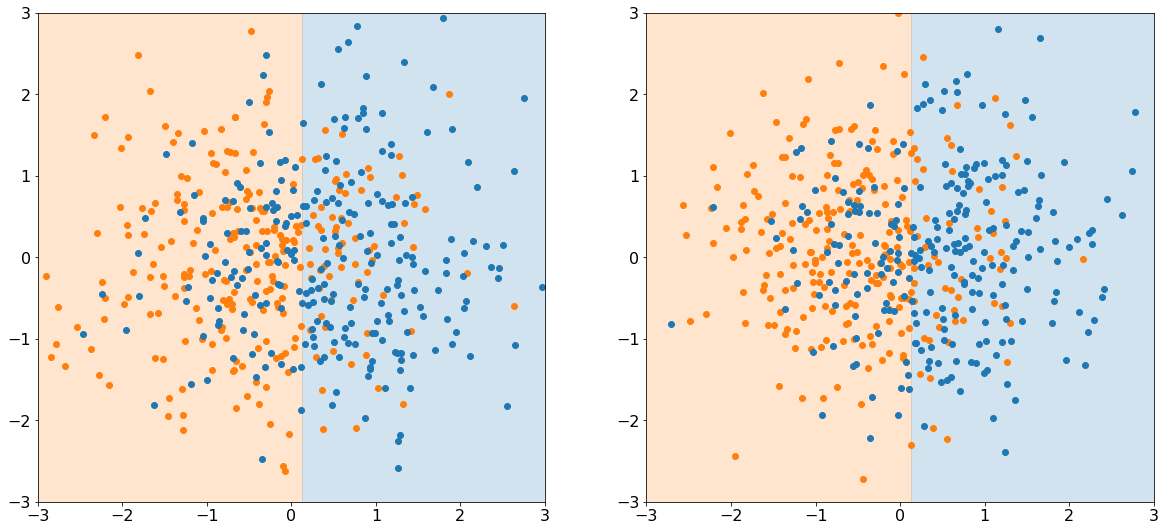

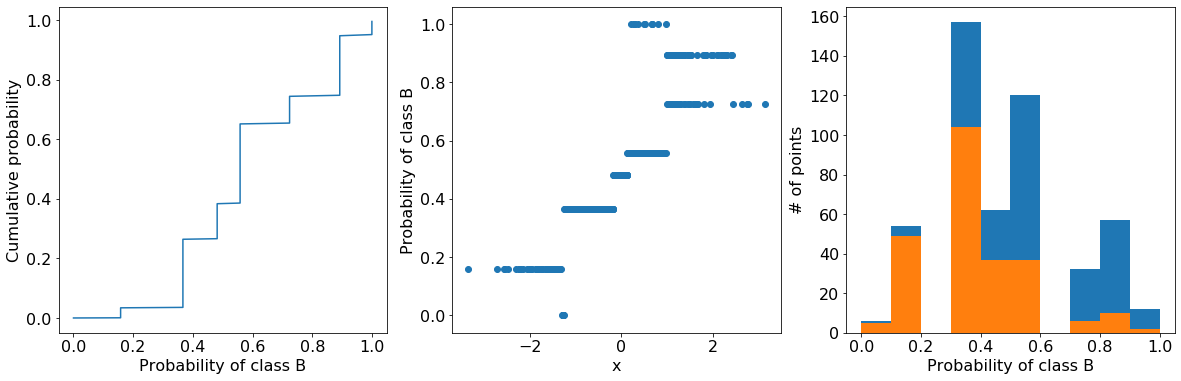

In [270]:
numpy.random.seed(27)
xy = numpy.random.normal(size=[500,2])
# shift x for one class to the left and for the other to the right
xy[...,0][:250] -= 0.5; xy[...,0][250:]+= 0.5
xytest = numpy.random.normal(size=[500,2])
xytest[...,0][:250] -= 0.5; xytest[...,0][250:]+= 0.5
classes = numpy.zeros(500).astype(int); classes[250:]=1
tshift = tree.DecisionTreeClassifier(max_depth=3).fit(xy, classes)
vals = tshift.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)

pyplot.figure(figsize=(20,9))
pyplot.subplot(1,2,1)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xy[...,0]), numpy.extract(classes==0, xy[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xy[...,0]), numpy.extract(classes==1, xy[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.subplot(1,2,2)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xytest[...,0]), numpy.extract(classes==0, xytest[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xytest[...,0]), numpy.extract(classes==1, xytest[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.draw()
fails=sum(tshift.predict(xy) ^ (classes).ravel())
print('Number of prediction fails for training sample: %d (%.1f%%))' % (fails, fails/len(xy)*100))
fails=sum(tshift.predict(xytest) ^ (classes).ravel())
print('Number of prediction fails for testing sample: %d (%.1f%%))' % (fails, fails/len(xytest)*100))

pyplot.figure(figsize=(20,6))
pyplot.subplot(1,3,1)
probs = tshift.predict_proba(xytest)[...,1]
probssort = numpy.sort(probs)
pyplot.plot(probssort, numpy.cumsum(probssort)/numpy.sum(classes==1))
pyplot.xlabel('Probability of class B')
pyplot.ylabel('Cumulative probability')
pyplot.subplot(1,3,2)
pyplot.scatter(xytest[...,0], tshift.predict_proba(xytest)[...,1])
pyplot.ylabel('Probability of class B')
pyplot.xlabel('x')
pyplot.subplot(1,3,3)
pyplot.hist([numpy.extract(classes==0, probs), numpy.extract(classes==1, probs)], stacked=True, color=['tab:orange', 'tab:blue'])
pyplot.xlabel('Probability of class B')
pyplot.ylabel('# of points')
pyplot.draw()

If you are trying to disentangle a signal of unknown size from a background, it is much better to use a "continuous" distribution (e.g. a probability score) in a fit than a single yes/no classifier decision. Basically, you'll preserve more information and will be less sensitive to precise uncertainties in how well you know the behavior of the classifier.  Also, a fit is useful because it uses the information from all events (even the signal events that don't look very signal-like).  Note that you do not _literally_ have to interpret the probability curve as a probability, merely as a number that increases as the purity of the signal improves.

A yes/no decision is more useful for something like selecting electrons, where the signal is expected to be quite pure and the normalization of the background is less important (or where there might be significant systematic uncertainties associated with background modeling).  Having a continuous score permits us to "tune" the classification, which can be very helpful if you need to suppress miscategorized events beyond what the decision tree training defaults to (or, conversely, need to accept more signal events because the background is less important than in the DT training sample).  The space of signal efficiency/background rejection possibilities is called a _receiver operating characteristic_ (ROC) curve, and is generally presented in particle physics as a curve of background rejection versus signal efficiency:

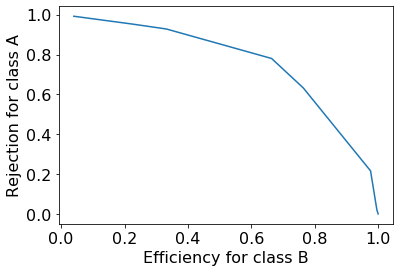

In [313]:
probs = tshift.predict_proba(xytest)[...,1]
probpoints = numpy.unique(probs)
yldA = numpy.array([sum((classes==0) & (probs >= _)) for _ in probpoints])
yldB = numpy.array([sum((classes==1) & (probs >= _)) for _ in probpoints])
rejA = 1-yldA/sum(classes==0)
effB = yldB/sum(classes==1)
pyplot.plot(effB, rejA)
pyplot.xlabel('Efficiency for class B')
pyplot.ylabel('Rejection for class A')
pyplot.draw()

The quality of the separation between the two classes is frequently quantified by taking the _area under the curve_ (AUC) - this will be 1 if the separation is perfect, 0.5 if there is no separation at all (i.e. if $\epsilon_A = \epsilon_B$ and the ROC curve is a diagonal line).  In this case, the AUC is 0.73.

In [294]:
# Use trapezoidal rule, reverse matrices to order effB from 0 to 1
print('AUC:', scipy.integrate.trapz(numpy.flip(rejA), numpy.flip(effB)))

AUC: 0.7269120000000001


## Improving Decision Trees

There are additional ways of extending the decision tree concept, to reduce the tendency to overfitting.  These use _multiple_ trees whose output is combined (e.g. by taking the most common result for classification, or the mean value for regression).  Among the methods:
* **Random Forests**: A large number of trees are trained. Each tree is trained with a new sample that is generated by drawing a random set of events from the original training sample (events can be drawn more than once - this is called _bootstrap aggregating_ or _bagging_).  During the training, a random set of features is considered at each split.  This means that each tree has a different set of training data and the generation of the tree is a bit more random.
* **Boosting**: This trains a number of trees in sequence, where the training of the next tree is directed in some way by the behavior of the previous trees.  The trees that are trained tend to be very short - maybe just one split (a "decision stump"); this reduces overtraining.  A couple of common boosting algorithms:
 * **AdaBoost** (adaptive boosting): the points that are misclassified by the classifier so far are given extra weight in the training of the next decision stump.
 * **Gradient boosting**: the next tree is trained in such a way as to maximally reduce some cost function when the classifier is applied to the training data (it attempts to choose the "most rapid decrease" function among all considered decision trees for the next step, hence "gradient").
 
It should be noted that these ensemble techniques (bagging, boosting) can be applied to classifiers other than decision trees (though DTs are by far the most common case).  AdaBoost can also be cast as a special case of gradient boosting with an appropriate cost function.  

Fraction correctly predicted in training/testing sample by various algorithms:
Random forest: train 69.2%, test 71.4%
AdaBoost: train 70.0%, test 66.6%
Gradient boosting: train 68.0%, test 69.8%


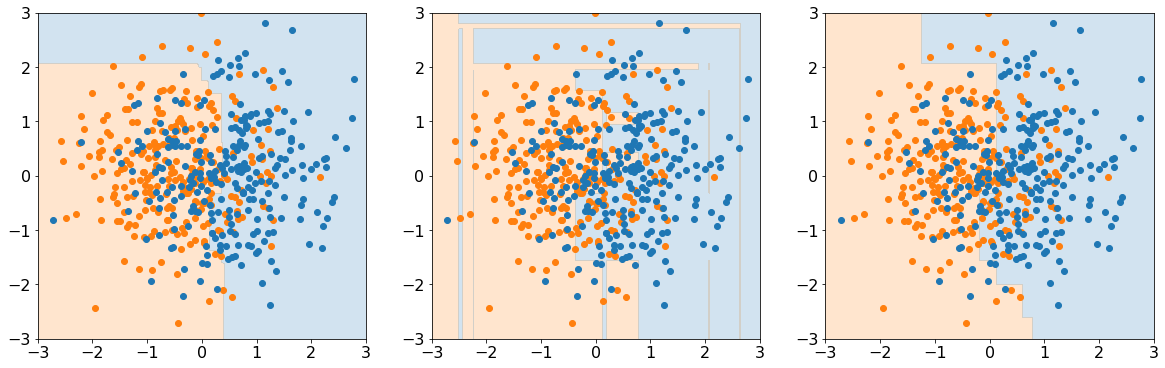

In [312]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# Force fixed random state
random_forest = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=91).fit(xy, classes)
# Default is depth=1 decision trees
adaboost = AdaBoostClassifier(random_state=91).fit(xy, classes)
# uses an entropy variable by default
gradboost = GradientBoostingClassifier(max_depth=1, random_state=91).fit(xy, classes)

pyplot.figure(figsize=(20,6))
pyplot.subplot(1,3,1)
vals = random_forest.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xytest[...,0]), numpy.extract(classes==0, xytest[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xytest[...,0]), numpy.extract(classes==1, xytest[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.subplot(1,3,2)
vals = adaboost.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xytest[...,0]), numpy.extract(classes==0, xytest[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xytest[...,0]), numpy.extract(classes==1, xytest[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.subplot(1,3,3)
vals = gradboost.predict(numpy.c_[xx.ravel(), yy.ravel()]).astype(float)
vals=vals.reshape(xx.shape)
pyplot.contourf(xx, yy, vals, levels=[-0.01, 0.99, 1.99], colors=['tab:orange', 'tab:blue'], alpha=0.2)
pyplot.scatter(numpy.extract(classes==0, xytest[...,0]), numpy.extract(classes==0, xytest[...,1]), label='Class A', color='tab:orange')
pyplot.scatter(numpy.extract(classes==1, xytest[...,0]), numpy.extract(classes==1, xytest[...,1]), label='Class B', color='tab:blue')
pyplot.xlim(-3,3); pyplot.ylim(-3,3)
pyplot.draw()
print('Fraction correctly predicted in training/testing sample by various algorithms:')
def corrects(predictor, sample):
    return (1-sum(predictor.predict(sample) ^ (classes).ravel())/len(sample))*100
print('Random forest: train %.1f%%, test %.1f%%' % (corrects(random_forest, xy), corrects(random_forest, xytest)))
print('AdaBoost: train %.1f%%, test %.1f%%' % (corrects(adaboost, xy), corrects(adaboost, xytest)))
print('Gradient boosting: train %.1f%%, test %.1f%%' % (corrects(gradboost, xy), corrects(gradboost, xytest)))


A note: XGBoost is a specific implementation of a boosting algorithm, which is designed to be fast.